In [1]:
import  pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
data1 = pd.read_csv('data/device1.csv')
data2 = pd.read_csv('data/device2.csv')

In [3]:
data1 = data1.iloc[:121598, :]

In [4]:
data1.shape, data2.shape

((121598, 11), (294938, 11))

In [5]:
df = pd.concat([data1, data2], ignore_index=True)  # Reset index


In [6]:
df.shape

(416536, 11)

In [7]:
df.columns

Index(['CO2', 'TVOC', 'PM10', 'PM2.5', 'CO', 'Air Quality', 'LDR', 'O3',
       'Temp', 'Hum', 'ts'],
      dtype='object')

In [8]:
df['ts'] = pd.to_datetime(df['ts'], errors='coerce')

# Extract components
# df['year'] = df['ts'].dt.year
df['month'] = df['ts'].dt.month
df['day'] = df['ts'].dt.day
df['hour'] = df['ts'].dt.hour
# df['minute'] = df['ts'].dt.minute
# df['second'] = df['ts'].dt.second

In [9]:
df.set_index("ts", inplace=True)  # Set timestamp as index


In [10]:
df.isna().sum()

CO2              0
TVOC             0
PM10             0
PM2.5            0
CO               0
Air Quality      0
LDR              0
O3               0
Temp             0
Hum              0
month          662
day            662
hour           662
dtype: int64

In [11]:
df.dropna(inplace=True)

In [12]:
df.columns

Index(['CO2', 'TVOC', 'PM10', 'PM2.5', 'CO', 'Air Quality', 'LDR', 'O3',
       'Temp', 'Hum', 'month', 'day', 'hour'],
      dtype='object')

In [13]:
import numpy as np

# Select numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Create a copy of the dataframe
df2 = df.copy()

# Initialize a variable to track the number of rows
previous_rows = df2.shape[0]

while True:
    # Calculate Q1, Q3, and IQR for numerical columns
    Q1 = df2[num_cols].quantile(0.25)
    Q3 = df2[num_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = ((df2[num_cols] < lower_bound) | (df2[num_cols] > upper_bound))

    # Remove rows with any outliers
    df2 = df2[~outliers.any(axis=1)]

    # Check the current number of rows
    current_rows = df2.shape[0]

    # If no rows were removed, stop the loop
    if current_rows == previous_rows:
        break
    
    # Update previous_rows for the next iteration
    previous_rows = current_rows

# df2 now contains the dataset with all outliers removed

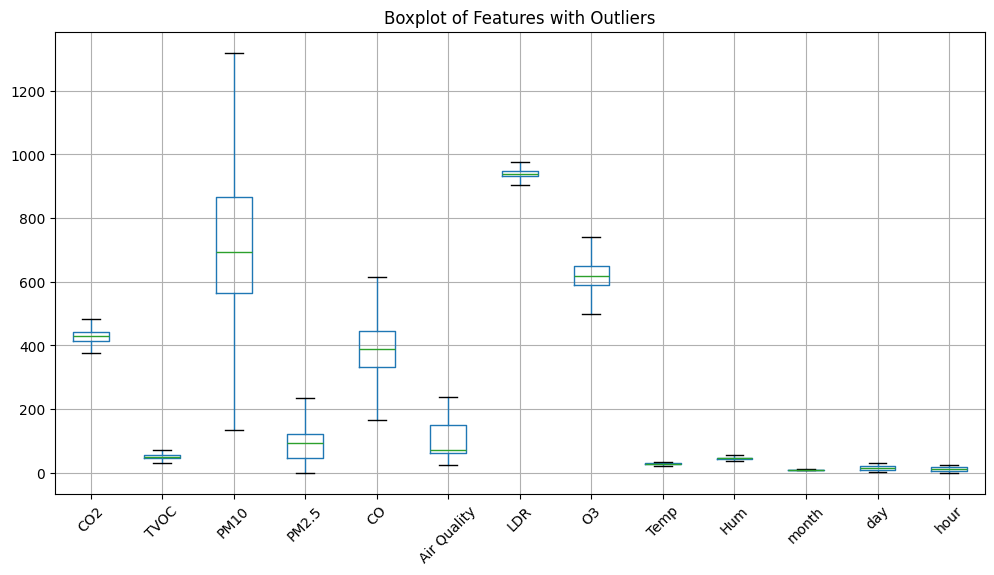

In [14]:
# Draw boxplots
plt.figure(figsize=(12, 6))
df2[num_cols].boxplot(rot=45)
plt.title("Boxplot of Features with Outliers")
plt.show()

In [15]:
df2.head()

,CO2,TVOC,PM10,PM2.5,CO,Air Quality,LDR,O3,Temp,Hum,month,day,hour
ts,,,,,,,,,,,,,
2024-07-01 10:26:02,449,42,1035.24,187.97,353,157,949,643,31.9,38.9,7.0,1.0,10.0
2024-07-01 10:28:00,425,48,675.67,136.32,332,143,944,625,29.2,41.5,7.0,1.0,10.0
2024-07-01 10:29:00,445,48,756.82,108.86,349,143,947,633,28.3,42.5,7.0,1.0,10.0
2024-07-01 10:30:04,405,38,808.61,137.47,319,143,953,618,27.5,44.0,7.0,1.0,10.0
2024-07-01 10:35:01,412,41,908.66,176.89,273,137,953,601,25.9,45.7,7.0,1.0,10.0


In [16]:
# Step 2: Calculate the time difference between consecutive rows
# `diff()` computes the difference between consecutive index values
time_diffs = df2.index.to_series().diff()

# Step 3: Convert the time differences to seconds
# `total_seconds()` converts the Timedelta to a float value in seconds
df2['diff_sec'] = time_diffs.dt.total_seconds()

# Optional: If you want to fill the NaN in the first row (e.g., with 0)
df2['diff_sec'] = df2['diff_sec'].fillna(0)

In [17]:
print(max(df2['diff_sec'])) 

327481.0


327481.0 secs are 3.79 days which I think it's not that bad 

In [18]:
df2.columns

Index(['CO2', 'TVOC', 'PM10', 'PM2.5', 'CO', 'Air Quality', 'LDR', 'O3',
       'Temp', 'Hum', 'month', 'day', 'hour', 'diff_sec'],
      dtype='object')

In [19]:
df2 = df2[df2.index< "2026-01-01"]


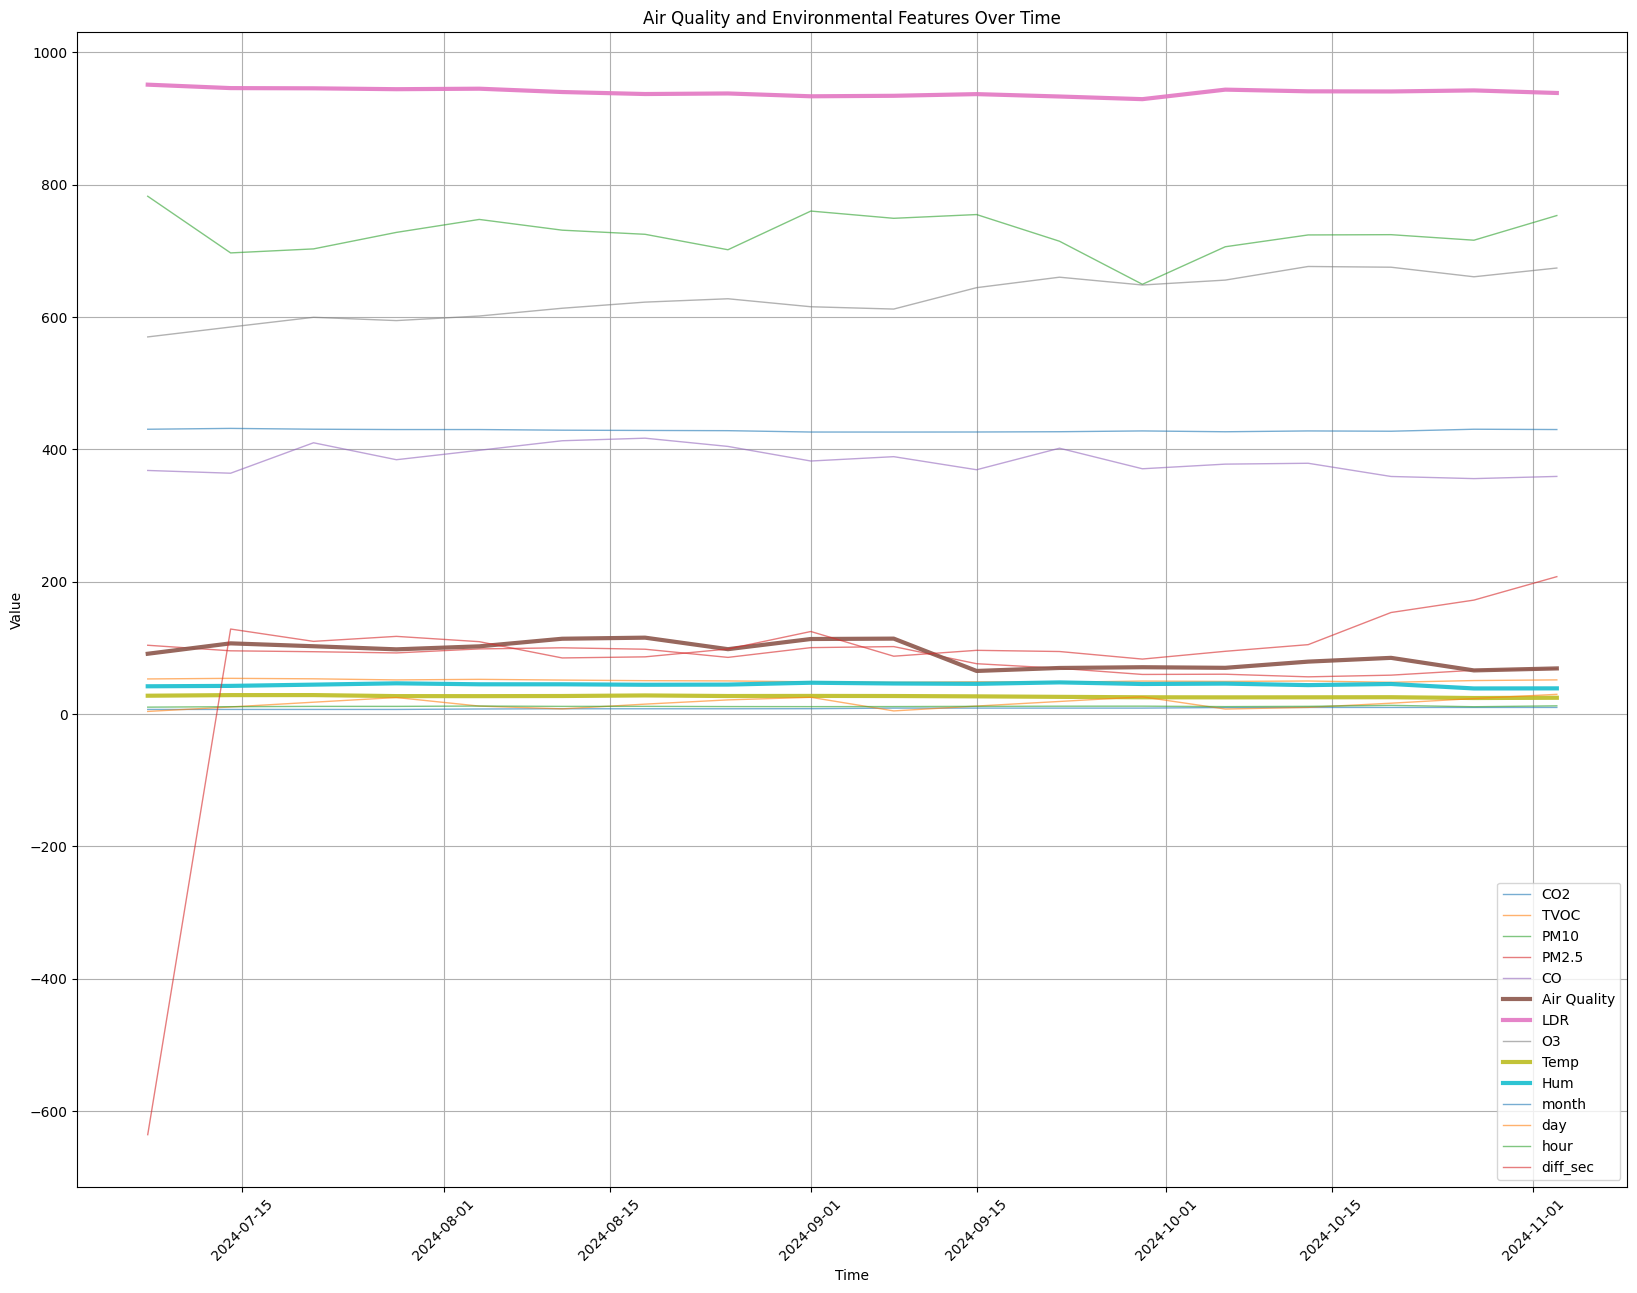

In [20]:
# Ensure the index is a datetime object
df2.index = pd.to_datetime(df2.index)

# Resample data to weekly or monthly (choose one)
df_resampled = df2.resample('W').mean()  # Weekly
# df_resampled = df.resample('M').mean()  # Monthly

# Plot
plt.figure(figsize=(20, 15))

# Define features to be bold
bold_features = ['Air Quality', 'Temp', 'Hum', 'LDR']

for column in df_resampled.columns:
    if column in bold_features:
        plt.plot(df_resampled.index, df_resampled[column], label=column, linewidth=3, linestyle='-', alpha=0.9)
    else:
        plt.plot(df_resampled.index, df_resampled[column], label=column, linewidth=1, linestyle='-', alpha=0.6)

# Formatting
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Air Quality and Environmental Features Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.show()


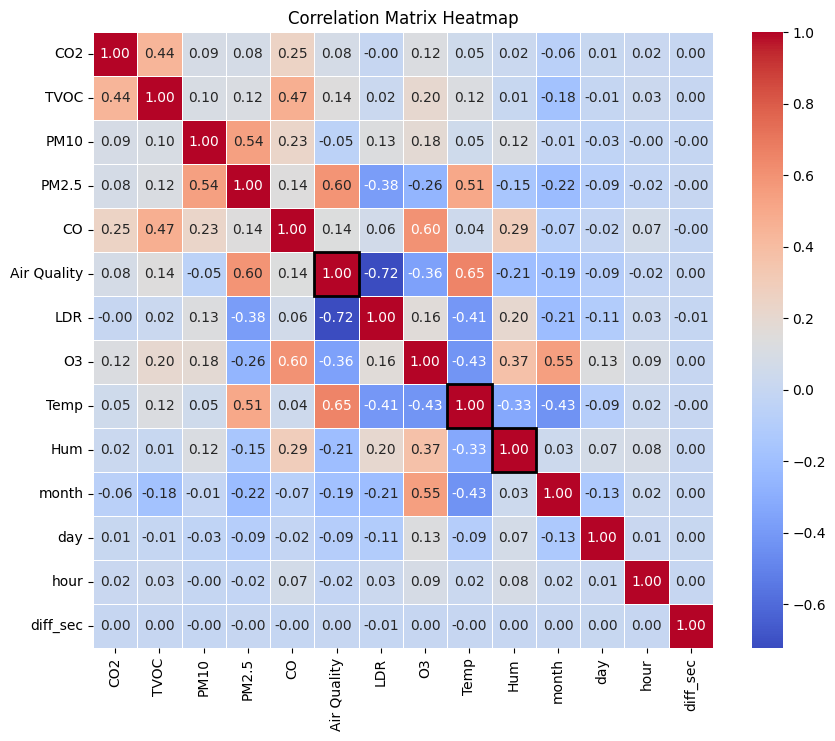

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the correlation matrix
corr_matrix = df2.corr()

# Define features to highlight
highlight_features = ['Air Quality', 'Temp', 'Hum']

# Create a mask to identify positions of the highlighted features
highlight_positions = [(corr_matrix.columns.get_loc(f), corr_matrix.index.get_loc(f)) for f in highlight_features]

# Plot the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Highlight selected features by adding a rectangle around them
for x, y in highlight_positions:
    rect = plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='black', lw=2)
    ax.add_patch(rect)

plt.title("Correlation Matrix Heatmap")
plt.show()


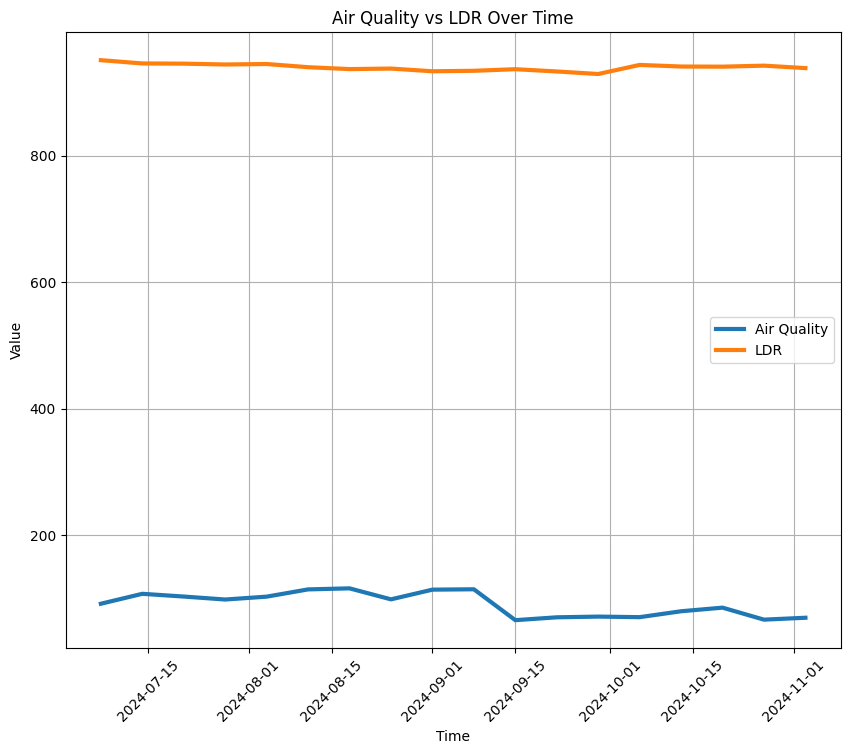

In [22]:
import matplotlib.pyplot as plt

# Ensure the index is a datetime object
df2.index = pd.to_datetime(df2.index)

# Resample data to weekly or monthly (choose one)
df_resampled = df2.resample('W').mean()  # Weekly
# df_resampled = df2.resample('M').mean()  # Monthly

# Select only 'Air Quality' and 'LDR' for plotting
selected_features = ['Air Quality', 'LDR']

plt.figure(figsize=(10, 8))

# Plot only the selected features
for column in selected_features:
    plt.plot(df_resampled.index, df_resampled[column], label=column, linewidth=3, linestyle='-')

# Formatting
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Air Quality vs LDR Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.show()


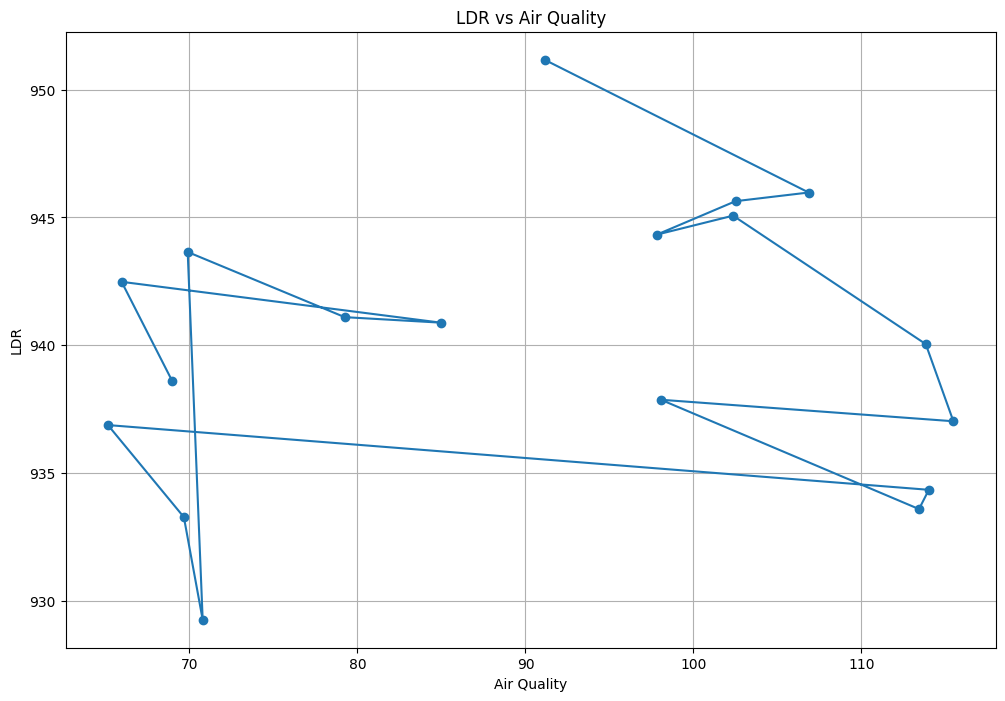

In [23]:
import matplotlib.pyplot as plt

# Ensure the index is a datetime object
df2.index = pd.to_datetime(df2.index)

# Resample data to weekly or monthly (choose one)
df_resampled = df2.resample('W').mean()  # Weekly
# df_resampled = df2.resample('M').mean()  # Monthly

# Plot LDR vs Air Quality
plt.figure(figsize=(12, 8))
plt.plot(df_resampled['Air Quality'], df_resampled['LDR'], marker='o', linestyle='-')

# Formatting
plt.xlabel("Air Quality")
plt.ylabel("LDR")
plt.title("LDR vs Air Quality")
plt.grid(True)

plt.show()


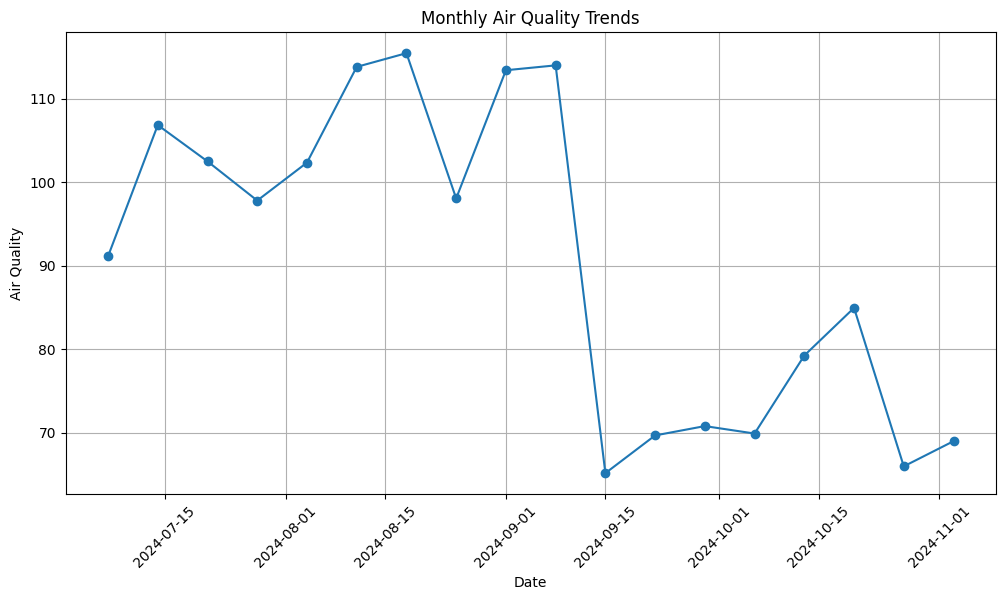

In [24]:
import matplotlib.pyplot as plt  

df_monthly = df2.resample("W").mean()  # Monthly mean air quality


plt.figure(figsize=(12, 6))  
plt.plot(df_monthly.index, df_monthly["Air Quality"], marker="o", linestyle="-")  
plt.xlabel("Date")  
plt.ylabel("Air Quality")  
plt.title("Monthly Air Quality Trends")  
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability  
plt.grid()  
plt.show()  

In [25]:
df2.columns

Index(['CO2', 'TVOC', 'PM10', 'PM2.5', 'CO', 'Air Quality', 'LDR', 'O3',
       'Temp', 'Hum', 'month', 'day', 'hour', 'diff_sec'],
      dtype='object')

In [26]:
df3 = df2[['LDR', 'Temp', 'PM2.5', 'Air Quality', 'month']]
df3 = df2.copy()

In [27]:
#import minmaxscaler
from sklearn.preprocessing import MinMaxScaler

num_cols = df3.select_dtypes(include=[np.number]).columns.tolist()

# Remove 'year' and 'month' safely if they exist
num_cols = [col for col in num_cols if col not in ["Air Quality"]]

# Apply MinMaxScaler
min_max_scaler = MinMaxScaler()
df4 = df3.copy()
df4[num_cols] = min_max_scaler.fit_transform(df3[num_cols])

In [28]:
df4.sort_index(ascending=True,inplace=True)

df4.head()

,CO2,TVOC,PM10,PM2.5,CO,Air Quality,LDR,O3,Temp,Hum,month,day,hour,diff_sec
ts,,,,,,,,,,,,,,
2024-07-01 10:02:01,0.626168,0.550,0.908462,0.488254,0.886667,40,1.0,0.555556,0.563025,0.446154,0.0,0.0,0.434783,0.000000
2024-07-01 10:03:00,0.448598,0.500,0.869040,0.499382,0.880000,40,1.0,0.543210,0.537815,0.441026,0.0,0.0,0.434783,0.947672
2024-07-01 10:12:01,0.616822,0.375,0.979219,0.837647,0.875556,41,1.0,0.539095,0.546218,0.410256,0.0,0.0,0.434783,0.947749
2024-07-01 10:13:00,0.523364,0.350,0.808863,0.301215,0.868889,40,1.0,0.547325,0.563025,0.425641,0.0,0.0,0.434783,0.947672
2024-07-01 10:14:00,0.233645,0.425,0.978360,0.626093,0.942222,40,1.0,0.572016,0.563025,0.430769,0.0,0.0,0.434783,0.947672


In [29]:
X = df4.drop(columns='Air Quality')
y = df4['Air Quality']

In [30]:
X.shape, y.shape

((153325, 13), (153325,))

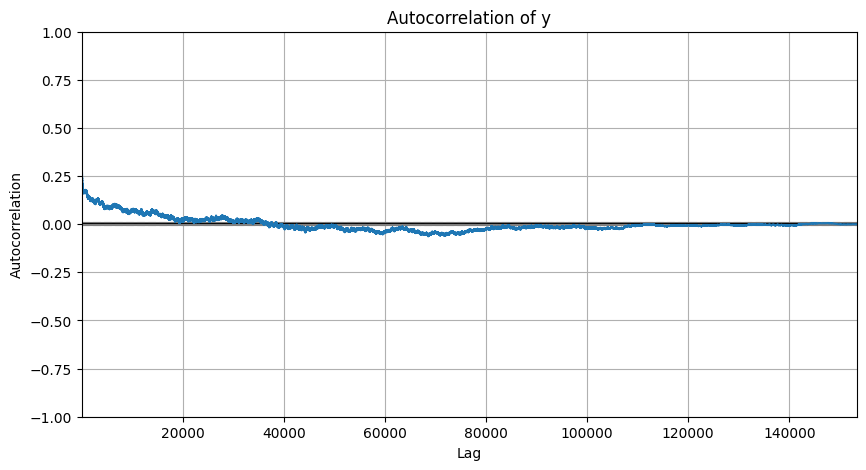

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf

# Autocorrelation plot of y
plt.figure(figsize=(10,5))
pd.plotting.autocorrelation_plot(y)
plt.title("Autocorrelation of y")
plt.show()


In [32]:
# import scipy.signal

# for i in range(X.shape[1]):
#     x_col = X.iloc[:, i].values  # Convert to NumPy array
#     y_values = y.values  # Convert y to NumPy array
#     corr = scipy.signal.correlate(x_col, y_values, mode="full")
#     plt.plot(corr, label=f' {df4.columns[i]}')

# plt.legend()
# plt.title("Cross-Correlation between X features and y")
# plt.show()


In [33]:
df4.columns

Index(['CO2', 'TVOC', 'PM10', 'PM2.5', 'CO', 'Air Quality', 'LDR', 'O3',
       'Temp', 'Hum', 'month', 'day', 'hour', 'diff_sec'],
      dtype='object')

In [34]:
X = df4[['CO2', 'TVOC', 'PM10', 'PM2.5', 'CO', 'Air Quality', 'LDR', 'O3','Temp', 'Hum']]
y = df4['Air Quality']

In [35]:
X

,CO2,TVOC,PM10,PM2.5,CO,Air Quality,LDR,O3,Temp,Hum
ts,,,,,,,,,,
2024-07-01 10:02:01,0.626168,0.550,0.908462,0.488254,0.886667,40,1.000000,0.555556,0.563025,0.446154
2024-07-01 10:03:00,0.448598,0.500,0.869040,0.499382,0.880000,40,1.000000,0.543210,0.537815,0.441026
2024-07-01 10:12:01,0.616822,0.375,0.979219,0.837647,0.875556,41,1.000000,0.539095,0.546218,0.410256
2024-07-01 10:13:00,0.523364,0.350,0.808863,0.301215,0.868889,40,1.000000,0.547325,0.563025,0.425641
2024-07-01 10:14:00,0.233645,0.425,0.978360,0.626093,0.942222,40,1.000000,0.572016,0.563025,0.430769
...,...,...,...,...,...,...,...,...,...,...
2024-10-31 23:42:03,0.672897,0.975,0.563311,0.421275,0.631111,71,0.458333,0.925926,0.184874,0.220513
2024-10-31 23:47:01,0.635514,0.925,0.709904,0.660925,0.597778,73,0.472222,0.909465,0.151261,0.246154
2024-10-31 23:48:01,0.672897,0.925,0.606186,0.265658,0.575556,69,0.472222,0.884774,0.151261,0.225641


In [36]:
sequence_length = 60
target_length = 60

X_sequences = []
y_sequences = []

for i in range(len(X) - sequence_length - target_length + 1):
    X_sequences.append(X[i:i+sequence_length])
    y_sequences.append(y[i+sequence_length:i+sequence_length+target_length])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [37]:
X_sequences.shape, y_sequences.shape

((153206, 60, 10), (153206, 60))

In [38]:
import tensorflow as tf 
# Convert to tensors
X_tensor = tf.convert_to_tensor(X_sequences, dtype=tf.float16)
y_tensor = tf.convert_to_tensor(y_sequences, dtype=tf.int32)

2025-03-12 19:12:19.181796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741799539.216437   29961 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741799539.227541   29961 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 19:12:19.313340: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1741799540.932811   29961 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 42

In [39]:
split = int(0.5 * len(X_sequences))


X_val =  X_tensor[:split]
y_val =  y_tensor[:split]

In [45]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, MultiHeadAttention, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_model(input_shape=(120, 5)):
    inputs = Input(shape=input_shape)

    # Convolutional block 1
    x = Conv1D(64, 5, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(64, 5, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)

    # Convolutional block 2
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)

    # Bidirectional LSTM block
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)

    # Self-attention mechanism
    attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = GlobalAveragePooling1D()(attn_output)

    # Dense layers with BatchNorm
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)  # Added
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)  # Added
    outputs = Dense(60)(x)  # Linear activation

    model = Model(inputs=inputs, outputs=outputs)

    return model


In [101]:
no_features = 10

input_shape = (60, no_features)
inputs = Input(shape=input_shape)

# Convolutional block 1
x = Conv1D(64, no_features, activation='relu', padding='same')(inputs)
# x = BatchNormalization()(x)
x = Conv1D(64, no_features, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)

# Convolutional block 2
x = Conv1D(128, 3, activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)

# Bidirectional LSTM block
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
# x = Dropout(0.3)(x)

# Global pooling instead of attention
x = GlobalAveragePooling1D()(x)

# Dense layers with BatchNorm
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
# x = BatchNormalization()(x)
outputs = Dense(60)(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)


In [102]:
# Initialize model
#model = build_model()

# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5)
]

# Train model (assuming X_train, y_train are prepared)
history = model.fit(
    X_tensor,
    y_tensor,
    
    validation_data=[X_val,y_val],
    epochs=10,
    batch_size=256,
    callbacks=callbacks
)

Epoch 1/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - loss: 2680.3489 - mae: 45.3919 - val_loss: 3065.0684 - val_mae: 50.6573 - learning_rate: 0.0100
Epoch 2/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2244.9561 - mae: 43.1935 - val_loss: 2859.5217 - val_mae: 50.8922 - learning_rate: 0.0100
Epoch 3/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2225.2810 - mae: 43.1330 - val_loss: 2906.9739 - val_mae: 50.8208 - learning_rate: 0.0100
Epoch 4/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2230.0681 - mae: 43.1961 - val_loss: 2785.1150 - val_mae: 51.0797 - learning_rate: 0.0100
Epoch 5/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2226.6628 - mae: 43.2455 - val_loss: 2832.0979 - val_mae: 50.9364 - learning_rate: 0.0100
Epoch 6/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 2229.1003 - mae: 43.2207 - val_loss: 2859.9587 - val_mae: 50.8868 - learning_rate: 0.0100
Epoch 7/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 2228.9072 - mae: 43.2478 -

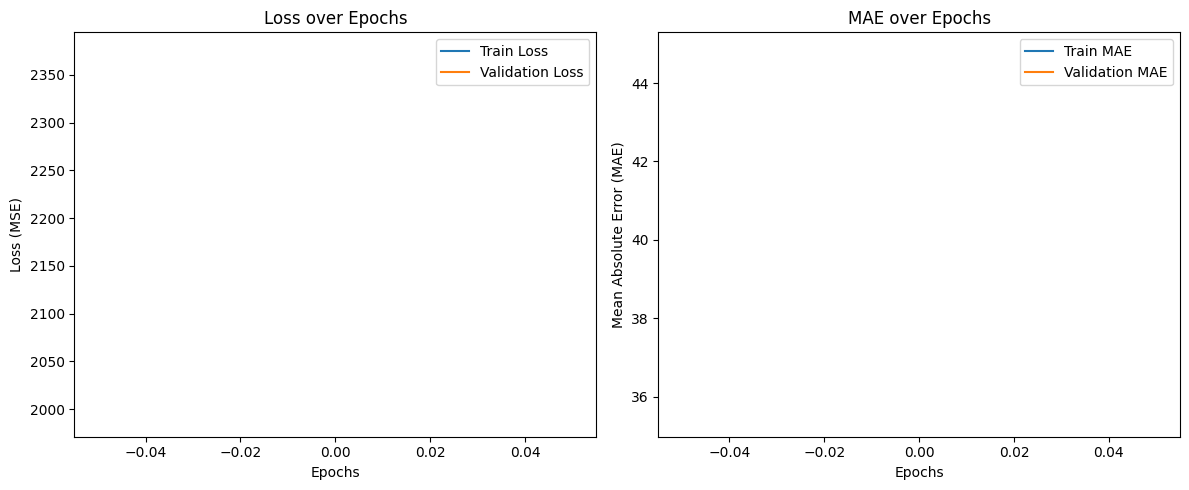

In [113]:
# import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Loss over Epochs')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [43]:

# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5)
]

# Train model (assuming X_train, y_train are prepared)
history = model.fit(
    X_tensor,
    y_tensor,
    validation_data=[X_val,y_val],
    epochs=40,
    batch_size=256,
    callbacks=callbacks
)

Epoch 1/40
597/597 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - loss: 0.0467 - mae: 0.1720 - val_loss: 0.0017 - val_mae: 0.0320 - learning_rate: 0.0010
Epoch 2/40
597/597 ━━━━━━━━━━━━━━━━━━━━ 79s 132ms/step - loss: 0.0352 - mae: 0.1504 - val_loss: 0.0011 - val_mae: 0.0252 - learning_rate: 0.0010
Epoch 3/40
597/597 ━━━━━━━━━━━━━━━━━━━━ 79s 132ms/step - loss: 0.0339 - mae: 0.1458 - val_loss: 0.0012 - val_mae: 0.0252 - learning_rate: 0.0010
Epoch 4/40
597/597 ━━━━━━━━━━━━━━━━━━━━ 79s 132ms/step - loss: 0.0329 - mae: 0.1417 - val_loss: 7.7408e-04 - val_mae: 0.0210 - learning_rate: 0.0010
Epoch 5/40
597/597 ━━━━━━━━━━━━━━━━━━━━ 79s 133ms/step - loss: 0.0325 - mae: 0.1399 - val_loss: 7.1349e-04 - val_mae: 0.0205 - learning_rate: 0.0010
Epoch 6/40
597/597 ━━━━━━━━━━━━━━━━━━━━ 79s 133ms/step - loss: 0.0319 - mae: 0.1375 - val_loss: 6.5018e-04 - val_mae: 0.0192 - learning_rate: 0.0010
Epoch 7/40
597/597 ━━━━━━━━━━━━━━━━━━━━ 77s 129ms/step - loss: 0.0315 - mae: 0.1362 - val_loss: 5.7888e-04 - val_mae: 

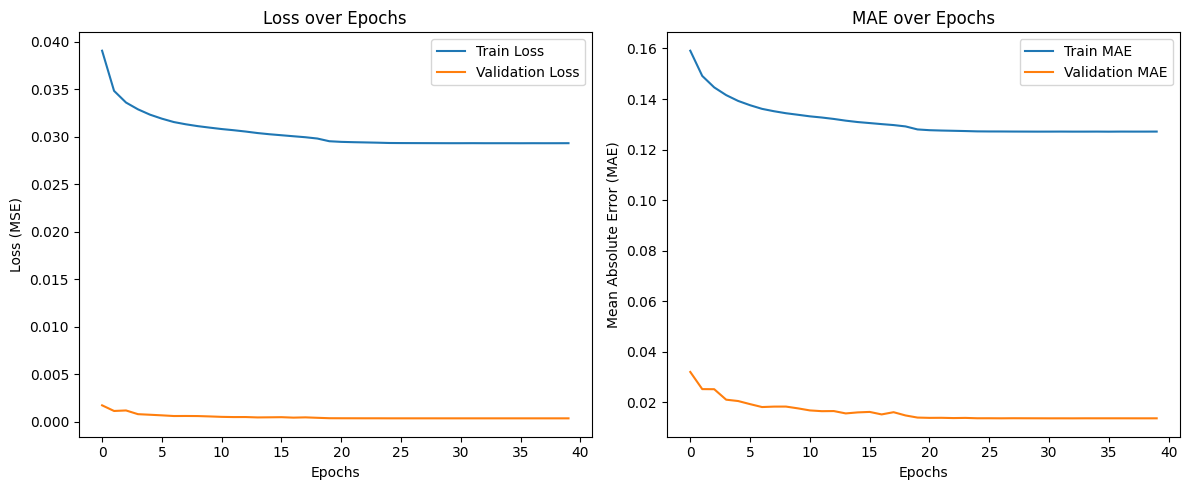

In [45]:
# import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Loss over Epochs')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

sequence_length = 60
num_features = 10

CNN_LSTM = Sequential([
    Input(shape=(sequence_length, num_features)),
    
    # CNN with regularization
    Conv1D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    SpatialDropout1D(0.2),
    BatchNormalization(),
    
    # LSTM with regularization
    LSTM(64, return_sequences=True, 
         dropout=0.3, recurrent_dropout=0.3,
         kernel_regularizer=l2(0.001)),
    
    TimeDistributed(Dense(1, activation='linear'))
])

# Use lower learning rate
optimizer = Adam(learning_rate=0.001)
CNN_LSTM.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [117]:
X.columns

Index(['CO2', 'TVOC', 'PM10', 'PM2.5', 'CO', 'Air Quality', 'LDR', 'O3',
       'Temp', 'Hum'],
      dtype='object')

In [116]:
X_tensor.shape, y_tensor.shape

(TensorShape([153206, 60, 10]), TensorShape([153206, 60]))

In [112]:
# Train with larger batch size if possible
history = CNN_LSTM.fit(X_tensor, y_tensor, 
                    epochs=5, 
                    batch_size=128,  # Increased from default 32
                    validation_split=0.2,
                    callbacks=[early_stop])

Epoch 1/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 67s 66ms/step - loss: 9202.4482 - mae: 80.1455 - mse: 9202.3447 - val_loss: 191.8555 - val_mae: 10.3170 - val_mse: 191.6900
Epoch 2/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 62s 64ms/step - loss: 3519.1379 - mae: 45.6997 - mse: 3518.9636 - val_loss: 519.8795 - val_mae: 20.9065 - val_mse: 519.6951
Epoch 3/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 63s 66ms/step - loss: 2630.5918 - mae: 47.8936 - mse: 2630.4084 - val_loss: 957.1860 - val_mae: 29.2768 - val_mse: 957.0154
Epoch 4/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 63s 66ms/step - loss: 2573.6514 - mae: 48.5841 - mse: 2573.4856 - val_loss: 1018.6758 - val_mae: 30.2828 - val_mse: 1018.5276


In [125]:
X_sequences.shape, y_sequences.shape

((153206, 60, 10), (153206, 60))

In [126]:
import numpy as np

def create_sequences(data, encoder_seq_len=60, decoder_seq_len=60, target_col=0):

    encoder_inputs = []
    decoder_inputs = []
    decoder_targets = []
    
    total_seq_len = encoder_seq_len + decoder_seq_len
    # Loop over the data to extract sequences
    for i in range(len(data) - total_seq_len + 1):
        # Encoder input: past 60 time steps (all features)
        enc_input = data[i : i + encoder_seq_len]
        
        # Decoder target: next 60 time steps for the target column
        dec_target_seq = data[i + encoder_seq_len : i + total_seq_len, target_col]
        
        # For training a decoder, we typically provide a shifted sequence as input.
        # Here we prepend a start token (e.g., 0.0) and remove the last value.
        start_token = 0.0  
        dec_input_seq = np.concatenate([[start_token], dec_target_seq[:-1]])
        
        encoder_inputs.append(enc_input)
        decoder_inputs.append(dec_input_seq)
        decoder_targets.append(dec_target_seq)
    
    return (np.array(encoder_inputs), 
            np.array(decoder_inputs), 
            np.array(decoder_targets))

# Example usage:
# Assuming 'data' is your full dataset with shape (total_time_steps, 10)
data = np.random.rand(153206 + 60 + 60 - 1, 10)  # Replace with your actual data

train_encoder_inputs, train_decoder_inputs, train_decoder_targets = create_sequences(data)

# Verify the shapes
print("Encoder Inputs:", train_encoder_inputs.shape)   # Expected: (num_samples, 60, 10)
print("Decoder Inputs:", train_decoder_inputs.shape)     # Expected: (num_samples, 60)
print("Decoder Targets:", train_decoder_targets.shape)   # Expected: (num_samples, 60)


Encoder Inputs: (153206, 60, 10)
Decoder Inputs: (153206, 60)
Decoder Targets: (153206, 60)


In [40]:
import tensorflow as tf

# Encoder: Processes the past 60 time steps with 10 features each.
class Encoder(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.lstm = tf.keras.layers.LSTM(hidden_dim, return_state=True)
    
    def call(self, x):
        # x shape: (batch, 60, 10)
        # Returns: hidden state and cell state
        _, hidden, cell = self.lstm(x)
        return hidden, cell

# Decoder: Generates the next 60 time steps for 1 target feature.
class Decoder(tf.keras.Model):
    def __init__(self, output_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.lstm = tf.keras.layers.LSTM(hidden_dim, return_sequences=True)
        self.fc = tf.keras.layers.Dense(output_dim)  # Projects LSTM outputs to the target dimension
    
    def call(self, x, initial_state):
        # x shape: (batch, 60, 1) - teacher-forced decoder input
        # initial_state: List [hidden, cell] from the encoder
        lstm_out = self.lstm(x, initial_state=initial_state)
        output = self.fc(lstm_out)  # output shape: (batch, 60, 1)
        return output

# Seq2Seq Model: Ties the encoder and decoder together.
class Seq2Seq(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def call(self, inputs):
        # Expects a tuple: (encoder_input, decoder_input)
        src, decoder_input = inputs
        hidden, cell = self.encoder(src)
        output = self.decoder(decoder_input, initial_state=[hidden, cell])
        return output

# Example initialization of the model components:
input_dim = 10   # Number of input features per time step
output_dim = 1   # Number of target features (air quality)
hidden_dim = 128 # Hidden state size

encoder = Encoder(input_dim, hidden_dim)
decoder = Decoder(output_dim, hidden_dim)
model = Seq2Seq(encoder, decoder)

# Model summary (build the model by providing dummy input)
dummy_src = tf.random.normal((1, 60, 10))    # One sample encoder input
dummy_dec_in = tf.random.normal((1, 60, 1))    # One sample decoder input
_ = model([dummy_src, dummy_dec_in])
model.summary()


I0000 00:00:1741799556.068906   30146 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model: "seq2_seq"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │        66,689 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,857 (538.50 KB)

 Trainable params: 137,857 (538.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the Seq2Seq model with an optimizer and a loss function.
model.compile(optimizer='adam', loss='mse')

# Fit the model using the training dataset and validate on the validation dataset.
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10)

# Optional: To inspect training history
print(history.history)

In [103]:
# import tensorflow as tf
# import numpy as np

def predict_future(input_tensor, model):
    """
    Make predictions using the trained sequence model
    
    Args:
        input_tensor: Input tensor of shape (512, 4)
        model: Trained Keras model
    
    Returns:
        prediction: Output tensor of shape (60,) 
    """
    # Add batch dimension and ensure correct dtype
    input_batch = tf.expand_dims(input_tensor, axis=0)
    input_batch = tf.cast(input_batch, tf.float32)
    
    # Make prediction
    prediction = model.predict(input_batch)
    
    # Remove batch dimension and convert to numpy array
    return tf.squeeze(prediction).numpy()



In [113]:
sample = 2500 
sample_input = X_tensor[sample]  

# Verify input shape
print("Input shape before expansion:", sample_input.shape)

# Build and test
# mymodel = build_model(input_shape=(120, 5))
prediction = predict_future(sample_input, CNN_LSTM)

print("\nOutput shape:", prediction.shape)
print("Sample predictions:", prediction)
print("Smaple real values:", y_tensor[sample+60])

Input shape before expansion: (60, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step

Output shape: (60,)
Sample predictions: [47.92451  61.793118 64.369835 64.74559  64.79844  64.80741  64.80748
 64.80865  64.8099   64.80977  64.809494 64.810036 64.80884  64.807236
 64.80971  64.80877  64.80688  64.8095   64.80946  64.8088   64.808044
 64.81049  64.8091   64.80937  64.80643  64.80737  64.806274 64.80728
 64.809044 64.80696  64.80883  64.80668  64.81001  64.81032  64.80945
 64.80974  64.80938  64.80986  64.80633  64.81012  64.809746 64.809875
 64.810104 64.81042  64.809906 64.810234 64.81021  64.809395 64.80873
 64.80817  64.80743  64.80699  64.80832  64.80785  64.81012  64.80919
 64.80826  64.80749  64.810936 64.805   ]
Smaple real values: tf.Tensor(
[168 169 167 166 162  41  46 154  34 161 151 152  40 154 144 145  33 149
  40 147 146  45 142  44 145 150  31 141 145 146 138  40 142 140 145 148
  44  40 148 150  41 149 144 150 150 150 145 147  44 147  46 143 146 142
 145 158 146  44  45 143],

In [63]:
def mse(A, B):
    return np.mean((A - B) ** 2)

In [114]:
mse(prediction,y_tensor[sample+60])

5485.8

In [343]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# sequence_length = 60
num_features = 4

CNN_LSTM = Sequential([
    Input(shape=(sequence_length, num_features)),
    
    # CNN with regularization
    Conv1D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    SpatialDropout1D(0.2),
    BatchNormalization(),
    
    # LSTM with regularization
    LSTM(64, return_sequences=True, 
         dropout=0.3, recurrent_dropout=0.3,
         kernel_regularizer=l2(0.001)),
    
    TimeDistributed(Dense(1, activation='linear'))
])


In [344]:
CNN_LSTM.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 512, 32)        │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 512, 32)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 512, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 512, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,441 (99.38 KB)

 Trainable params: 25,377 (99.13 KB)

 Non-trainable params: 64 (256.00 B)

X_sequences.shape, y_sequences.shape
((152754, 512, 4), (152754, 60))

I want the past 512row x 4 features samples predict the future 60 sample 
regresion model 
make a complex model to fit my data 

In [345]:

# Use lower learning rate
optimizer = Adam(learning_rate=0.001)
CNN_LSTM.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train with larger batch size if possible
history = CNN_LSTM.fit(X_tensor, y_tensor, 
                    epochs=10, 
                    batch_size=128,  # Increased from default 32
                    validation_split=0.2,
                    callbacks=[early_stop])

Epoch 1/10


2025-03-11 01:49:50.610767: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1001086976 exceeds 10% of free system memory.


ValueError: Dimensions must be equal, but are 60 and 512 for '{{node compile_loss/mae/sub}} = Sub[T=DT_FLOAT](compile_loss/mae/Cast, compile_loss/mae/Squeeze)' with input shapes: [?,60], [?,512].